In [1]:
%run code/disable_visa.py  # Initialization code to disable VISA functionality
%run code/mocks.py  # Create fake acquisition signal parameter

In [20]:
import qcodes as qc
from qcodes import load_data

import tempfile  
qc.set_data_root_folder(tempfile.mkdtemp())  # Set data storage folder to a temporary path
%matplotlib notebook

Data root folder set to C:\Users\Serwan\AppData\Local\Temp\tmp0m144j3j


# Brief QCoDeS guide

Since QCoDeS is at the foundation of SilQ, we will first give a brief guide
on the main concepts of QCoDeS.
This page is intended to be a short interactive guide that introduces the most important principles of QCoDeS.
It is by no means intended to be a comprehensive guide.
The notebook can be run by starting Jupyter Notebook and navigating to `SilQ/docs/Brief QCoDeS guide.ipynb`.

For more information, please see the documentation website of 
[QCoDeS](http://qcodes.github.io/Qcodes/).
However, please remember that our group uses a version of QCoDeS that has
diverged from the main QCoDeS, and so some sections are not relevant to us
(in particular the new DataSet and measuring method).
Additionally, the [in-depth guides](in-depth guides/index.rst) section contains
information about specific parts of QCoDeS.

## Instruments

An experimental setup generally consists of instruments with specific functions.
QCoDeS has a plethora of drivers for different instruments, each of which is
a subclass of the Instrument class.
For a list of drivers, see the [instrument drivers webpage](http://qcodes.github.io/Qcodes/api/generated/qcodes.instrument_drivers.html)
or the QCoDeS source code.

A physical instrument is represented by QCoDeS by the `Instrument` class.
This class is meant to facilitate communication with the physical instrument 
and record the current instrument settings.
Each `Instrument` generally has a connection mode (e.g. GPIB, ethernet) and a
connection address (e.g. ``GPIB0::5::INSTR``) to the physical instrument.

As an example, we will connect to the Keysight E8267D microwave source.
For the purpose of this tutorial, we have disabled VISA communication, so it is safe to run these commands.

The first step is to load the driver class corresponing to the instrument:

In [3]:
from qcodes.instrument_drivers.Keysight.E8267D import Keysight_E8267D

Once the driver is loaded, we can initiate a connection.
Here we assume that the connection is via GPIB address `GPIB0::5::INSTR`.
The actual address can usually be found either on the instrument, or through an application such as NI MAX.

An instrument should always have a name, which in this case is `microwave_source`

In [4]:
microwave_source = Keysight_E8267D(name='microwave_source', address='GPIB0::5::INSTR')

Connected to: None microwave_source (serial:None, firmware:None) in 0.00s


Once the `Instrument` is instantiated, we can print a snapshot of all its parameter settings.
Initially, all parameters are set to `None` because they have not been explicitly set.

In [5]:
microwave_source.print_snapshot()

microwave_source :
	parameter                  value
--------------------------------------------------------------------------------
IDN                         :	{'vendor': None, 'model': 'microwave_source', '...
RF_output                   :	None 
amplitude_modulation        :	None 
automatic_leveling_control  :	None 
frequency                   :	None (Hz)
frequency_deviation         :	None 
frequency_modulation        :	None 
frequency_modulation_source :	None 
internal_IQ_modulation      :	None 
internal_arb_system         :	None 
output_modulation           :	None 
phase                       :	None (deg)
phase_modulation            :	None 
power                       :	None (dBm)
pulse_modulation            :	None 
pulse_modulation_source     :	None 
timeout                     :	5 (s)


Information on the `ParameterNode`, which is the parent class of the Instrument, can be found at [ParameterNode guide](in-depth guides/ParameterNode guide.rst)

## Parameters

Each of the parameters listed above is an instance of a QCoDeS `Parameter`.
A `Parameter` corresponds to a setting of an `Instrument`, and can have a get and/or set functionality attached to it.

In the case of the microwave frequency, it has both functionalities.
We can access the `Parameter` object by accessing the `Instrument` attribute

In [6]:
microwave_source.frequency

<qcodes.instrument.parameter.Parameter: frequency at 1525537617064>

We can set the value by placing the new value within brackets:

In [7]:
microwave_source.frequency(42e9)

Note that this send an actual instruction to the instrument, which will then modify its frequency.

We can also get the current frequency by placing nothing in the brackets:

In [8]:
microwave_source.frequency()

42000000000.0

Parameters are important because they are the objects that are varied and measured in a measurement Loop (next section).

Note that the Parameter has many feaures, including limits, ramp rates and delays.
More information on the parameter can be found at [Parameter guide](in-depth guides/Parameter guide.rst)

## Performing a measurement: Loop, Dataset, MatPlot

<span style="color:red">
    **WARNING:** The measurement scheme has been upgraded in our new version of QCoDeS. 
    The examples here need to be updated. 
    A short list of examples using the new scheme is shown at the bottom of the page
</span>.

Generally speaking, a measurement usually consists of varying one or more parameters and measuring something for each of these parameter values.
These are precisely what Parameters are for: they facilitate varying something (via its `set` function), or measuring something (via its `get` function).

To give an example, say we have a device containing some two-level system, and we want to measure its frequency response.
For the sake of this tutorial, let's assume that we have the following parameter that can measure the signal from our device:

In [9]:
DC_signal_parameter = FakeSignalParameter('DC_signal')

We can retrieve the current DC signal by calling this parameter:

In [10]:
DC_signal_parameter()

6.167450778682104e-09

Let's assume we know it has a resonance frequency around 42.1 GHz, and so we want to measure the signal from this device for a range of frequencies around this frequency.
In QCoDeS, we can achieve this using the following piece of code:

DataSet:
   data = load_data('data/2019-03-12/#032_frequency_sweep_12-56-00')
   <Type>   | <array_id>                     | <array.name> | <array.shape>
   Setpoint | microwave_source_frequency_set | frequency    | (41,)
   Measured | microwave_source_DC_signal     | DC_signal    | (41,)


<IPython.core.display.Javascript object>


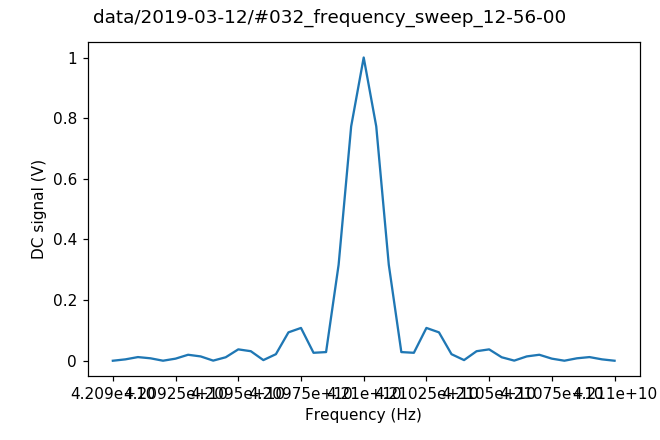

c:\users\serwan\documents\github\silq\qcodes\qcodes\plots\qcmatplotlib.py:531: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(abs(trace['config'][axis].ndarray))


In [11]:
%%measurement frequency_sweep
for microwave_source.frequency.sweep(42.09e9, 42.11e9, num=41):
    DC_signal_parameter
    
loop.plot(data.microwave_source_DC_signal)
loop.run()

Let's dissect this measurement line by line.

1. `%%measurement frequency_sweep`  
   This line should be placed at the top of the cell, to indicate that a measurement is being defined.  
   The second part (`frequency_sweep`) is the name we give to the measurement.
2. `for microwave_source.frequency.sweep(42.09e9, 42.11e9, num=41):`  
   Here we take the `microwave_source.frequency` parameter and tell it that it should sweep its value
   between 42.09 GHz and 42.11 GHz, using 101 frequency values.
   Any Parameter that has a `set` function defined can be used for sweeping values
3. `    DC_signal_parameter`  
   This line is indented because it is happening within the frequency sweep loop.
   Placing the Parameter here indicates that its value should be measured and saved for each iteration in the loop.
   Any Parameter that has a `get` function defined can be used for measuring.
   Note the lack of brackets `()`.
4. `  `  
   An empty line indicates that the measurement definition is finished.
5. `loop.plot(data.microwave_source_DC_signal)`  
   This line indicates that while the measurement is running, the measured DC signal should be plotted.
6. `loop.run()`  
   This final line indicates that the measurement should start. 

Note that defining a measurement using `%%measurement` only works in an IPython environment, for more information run `?measurement`.

If all goes well, the measurement should be busy for a while (visible by a star next to the cell), and a plot of the measured DC signal should be updating.
If you do not see a plot of the signal, please make sure you ran the top cell containing `%matplotlib notebook`.

Once the measurement is complete, it is directly accessible via

In [12]:
data

DataSet:
   data = load_data('data/2019-03-12/#032_frequency_sweep_12-56-00')
   <Type>   | <array_id>                     | <array.name> | <array.shape>
   Setpoint | microwave_source_frequency_set | frequency    | (41,)
   Measured | microwave_source_DC_signal     | DC_signal    | (41,)

the data is also stored within the data root folder (see top cell), and we can load this data using the second output line:

In [13]:
data = qc.load_data('data/2019-03-12/#030_frequency_sweep_12-53-09')  # Remember to replace this with your second line
data

DataSet:
   data = load_data('data/2019-03-12/#030_frequency_sweep_12-53-09')
   <Type>   | <array_id>                     | <array.name> | <array.shape>
   Setpoint | microwave_source_frequency_set | frequency    | (41,)
   Measured | microwave_source_DC_signal     | DC_signal    | (41,)

The DataSet output shows two lines, the first is the `microwave_source_frequency_set` containing the microwave frequency setpoints:

In [14]:
data.microwave_source_frequency_set

DataArray[41]: microwave_source_frequency_set
array([4.20900e+10, 4.20905e+10, 4.20910e+10, 4.20915e+10, 4.20920e+10,
       4.20925e+10, 4.20930e+10, 4.20935e+10, 4.20940e+10, 4.20945e+10,
       4.20950e+10, 4.20955e+10, 4.20960e+10, 4.20965e+10, 4.20970e+10,
       4.20975e+10, 4.20980e+10, 4.20985e+10, 4.20990e+10, 4.20995e+10,
       4.21000e+10, 4.21005e+10, 4.21010e+10, 4.21015e+10, 4.21020e+10,
       4.21025e+10, 4.21030e+10, 4.21035e+10, 4.21040e+10, 4.21045e+10,
       4.21050e+10, 4.21055e+10, 4.21060e+10, 4.21065e+10, 4.21070e+10,
       4.21075e+10, 4.21080e+10, 4.21085e+10, 4.21090e+10, 4.21095e+10,
       4.21100e+10])

The second line is `microwave_source_DC_signal`, and contains the measured frequencies

In [15]:
data.microwave_source_DC_signal

DataArray[41]: microwave_source_DC_signal
array([6.06465762e-05, 4.58002586e-03, 1.21030523e-02, 8.07594018e-03,
       1.46665607e-04, 6.92568467e-03, 1.97517948e-02, 1.43114823e-02,
       4.54210875e-04, 1.15279398e-02, 3.75385359e-02, 3.14838723e-02,
       2.17233406e-03, 2.16628124e-02, 9.36418548e-02, 1.08191365e-01,
       2.62631122e-02, 2.85982132e-02, 3.16563836e-01, 7.72812970e-01,
       1.00000000e+00, 7.72812970e-01, 3.16563836e-01, 2.85982132e-02,
       2.62631122e-02, 1.08191365e-01, 9.36418548e-02, 2.16628124e-02,
       2.17233406e-03, 3.14838723e-02, 3.75385359e-02, 1.15279398e-02,
       4.54210875e-04, 1.43114823e-02, 1.97517948e-02, 6.92568467e-03,
       1.46665607e-04, 8.07594018e-03, 1.21030523e-02, 4.58002586e-03,
       6.06465762e-05])

We can plot this data using `qc.MatPlot`, which is based on the Python matplotlib package, and adds functionality related to the QCoDeS DataSet:

<IPython.core.display.Javascript object>


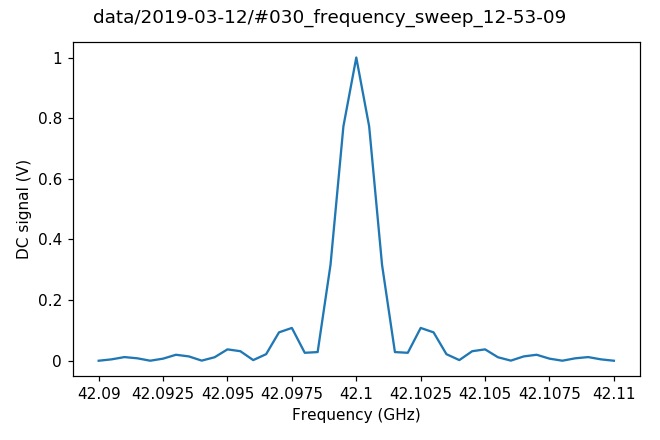

In [16]:
plot = qc.MatPlot(data.microwave_source_DC_signal)

One thing you will notice is that it automatically fills in the frequency setpoints, and even handles things such as units.
This is because the DC_signal array contains a link to its setpoint array (in this case microwave_frequency).

## 2D measurement

This concept can easily be extended to multidimensional measurement loops.
As an example, let's say we want to measure the DC signal both as a function of frequency and power.
In this case we simply use nested for loops:

In [17]:
DC_signal_parameter.delay = 0.01  # We reduce the fake acquisition delay to speed up the measurement loop

DataSet:
   data = load_data('data/2019-03-12/#033_frequency_sweep_12-56-12')
   <Type>   | <array_id>                     | <array.name> | <array.shape>
   Setpoint | microwave_source_power_set     | power        | (17,)
   Setpoint | microwave_source_frequency_set | frequency    | (17, 41)
   Measured | microwave_source_DC_signal     | DC_signal    | (17, 41)


<IPython.core.display.Javascript object>


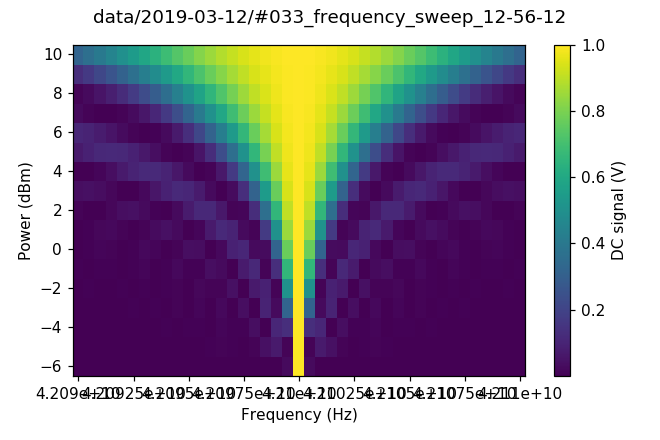

c:\users\serwan\documents\github\silq\qcodes\qcodes\plots\qcmatplotlib.py:531: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(abs(trace['config'][axis].ndarray))


In [18]:
%%measurement frequency_sweep
for microwave_source.power.sweep(-6, 10, 1):
    for microwave_source.frequency.sweep(42.09e9, 42.11e9, num=41):
        DC_signal_parameter
    
loop[0].plot(data.microwave_source_DC_signal)
loop.run()

We clearly see that the resonance peak is power broadened the higher the output power.

## Examples of new QCoDeS measurement scheme

## Start measurement using:
```Python
from qcodes import Measurement, Sweep

with Measurement('measurement_name') as msmt:
```
The `msmt` object is now your way to access properties of the running measurement
This also creates the two variables `msmt` and `data` in your local scope

## Ways to measure
```Python
# Measure a single value
msmt.measure(123, 'my_value', unit='s')

# Measure a dictionary of values
d = {'a': 1, 'b': 2}
msmt.measure(d, 'my_dickt_values')

# Measure a parameter
p = Parameter('my_parameter', initial_value=42)
msmt.measure(p)

# Measure a multi parameter
msmt.measure(NMR_parameter)
```

## Ways to sweep:

```Python
for k in Sweep(range(40), 'repetition'):

param = Parameter('sweep_parameter', set_cmd=None)
for k in Sweep(param.sweep(0, 10, step=2)):
for k in Sweep(param[0:10:2]):
```

You can also perform a loop without adding a sweep:

```Python
gates = [PL, TG, DBL]
for gate in gates:
    msmt.measure(gate)
```

## A basic measurement
```Python
import numpy as np
with Measurement('my_measurement') as msmt:
    p = Parameter('measured_parameter', get_cmd=np.random.rand)
    
    for sweep_val in Sweep(range(12), 'repetition'):
        msmt.measure(p)
        
        if sweep_val > 5:
            msmt.measure(sweep_val + 2, 'sweep_value_plus_two')
        
# data.measured_parameter  # Doesn't exist
data['measured_parameter']
data.get_arrays('measured_parameter')
```

## Nested measurements

### Basic example
```Python
with Measurement('Outer measurement') as msmt:
    for k in Sweep(range(10), 'repetition'):
        with Measurement('inner_measurement') as msmt2:
            msmt.measure(np.random.rand(), 'random_value')
```

Why is this useful?

```Python
# Define function
def measure_ESR_spectrum(f0):
    with Measurement('ESR_spectrum') as msmt:
        ESR_parameter.setup()
        for frequency in Sweep(microwave.frequency.sweep(f0 -1e6, f0 + 1e6, step=100e3)):
            msmt.measure(ESR_parameter)
            
# Perform measurement
# Each ESR spectrum is nested into the main measurement
with Measurement('repeated_spectrum_scan') as msmt:
    for k in Sweep(range(10), 'repetition'):
        measure_ESR_spectrum(f0=28e9)
        

# Can also perform measurement by calling the function
measure_ESR_spectrum(f0=28e9)
```


## Masking objects
### Masking parameter
```Python

param = Parameter('my_param', initial_value=42)
with Measurement('mst_with_masking') as msmt:
    msmt.mask(param, 41)
    
    
    msmt.measure(param)  # This measures 41
    
print(param())  # Prints 42, original value is returned
```


### Masking parameter
```Python

param = Parameter('my_param', initial_value=42)
with Measurement('mst_with_masking') as msmt:
    msmt.mask(param, 41)
    
    
    msmt.measure(param)  # This measures 41
    
print(param())  # Prints 42, original value is returned
```